# Math 607 HW 4
### Sean Ericson 6/10/2024

In [1]:
# Imports
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
mpl.rcParams["animation.html"] = "jshtml"

## Ising Model

In [55]:
# Code
def Ising_Hamiltonian(σ, J, μ):
    n = σ.shape[0]
    return -J*sum([(σ[i, j]*σ[i, j+1] if j < n-1 else 0) + (σ[i, j]*σ[i+1, j] if i < n-1 else 0) for i in range(n) for j in range(n)]) -μ*σ.sum()

def neighbor_indices(n, i, j):
    nebs = []
    if i > 0:
        nebs.append((i-1, j))
    if j > 0:
        nebs.append((i, j-1))
    if i < n-1:
        nebs.append((i+1, j))
    if j < n-1:
        nebs.append((i, j+1))
    return nebs

def step_spins(σ, J, μ, β, site=None):
    n = σ.shape[0]
    if site is not None:
        i,j = site
    else:
        i,j = np.random.randint(n, size=2)
    neb_sum = sum([σ[x, y] for x,y in neighbor_indices(n, i, j)])
    ΔH = 2*σ[i,j]*(J*neb_sum + μ)
    prob = 1 if ΔH <= 0 else np.exp(-β*ΔH)
    if np.random.rand() < prob:
        σ[i,j] *= -1

def plot_spins(σ, ax):
    ax.axis('off')
    ax.imshow(σ, cmap="Greys", vmin=-1, vmax=1)

In [53]:
N = 20
high = np.ones((N,N))
low = -1*np.ones((N,N))
J = 1
μ = .0
β = 1
lows = [np.array(low)]
highs = [np.array(high)]
low_Hs = [Ising_Hamiltonian(low, J, μ)]
high_Hs = [Ising_Hamiltonian(high, J, μ)]
sample = None
while not np.array_equal(low, high):
    site = np.random.randint(N, size=2)
    step_spins(low, J, μ, β, site)
    step_spins(high, J, μ, β, site)
    lows.append(np.array(low))
    highs.append(np.array(high))
    low_Hs.append(Ising_Hamiltonian(lows[-1], J, μ))
    high_Hs.append(Ising_Hamiltonian(highs[-1], J, μ))

for _ in range(100):
    site = np.random.randint(N, size=2)
    step_spins(low, J, μ, β, site)
    step_spins(high, J, μ, β, site)
    lows.append(np.array(low))
    highs.append(np.array(high))
    low_Hs.append(Ising_Hamiltonian(lows[-1], J, μ))
    high_Hs.append(Ising_Hamiltonian(highs[-1], J, μ))

sample = lows[-1] if np.random.rand() < 0.5 else highs[-1]
print(len(lows))

KeyboardInterrupt: 

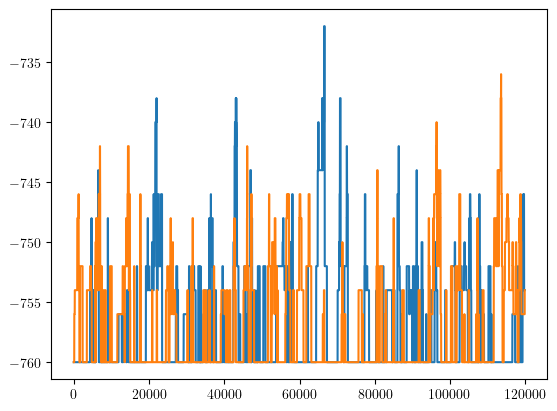

In [54]:
xs = list(range(len(lows)))
plt.plot(xs, low_Hs)
plt.plot(xs, high_Hs)

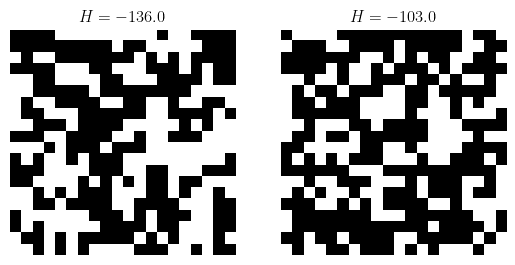

In [50]:
fig, ax = plt.subplots(1, 2)
plot_spins(lows[-1], ax[0])
plot_spins(highs[-1], ax[1])
ax[0].set_title("$H = {}$".format(low_Hs[-1]))
ax[1].set_title("$H = {}$".format(high_Hs[-1]))
plt.show()

In [24]:
fig, ax = plt.subplots(1, 2)
def update(frame):
    plt.cla()
    plot_spins(lows[frame], ax[0])
    plot_spins(highs[frame], ax[1])
    ax[0].set_title("$H = {}$".format(Ising_Hamiltonian(lows[0], J, μ)))
    ax[1].set_title("$H = {}$".format(Ising_Hamiltonian(highs[0], J, μ)))
    
anim = animation.FuncAnimation(fig, update, len(lows), interval=20)
plt.close()

In [26]:
display(anim)

## Continuous time markov chains

## Simulation of continuous time random walk

In [125]:
def simulate_walk(time, λ=1, D=5):
    state = np.zeros(D)
    step_times = sorted(np.random.uniform(0, time, np.random.poisson(λ*time)))
    states = [(0, np.array(state))]
    for t in step_times:
        n = np.random.randint(D)
        state[n] = 1 - state[n]
        states.append((t, np.array(state)))
    return states

def sample_walk(walk, times):
    step_times, states = zip(*walk)
    state_samples = []
    for t in times:
        latter_step_times = [step_time for step_time in step_times if step_time > t]
        if len(latter_step_times) == 0:
            state_samples.append(states[-1])
        else:
            next_step_time = latter_step_times[0]
            state_samples.append(states[step_times.index(next_step_time) - 1])
    return state_samples


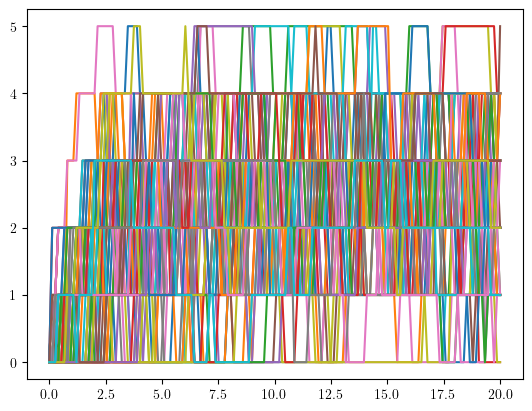

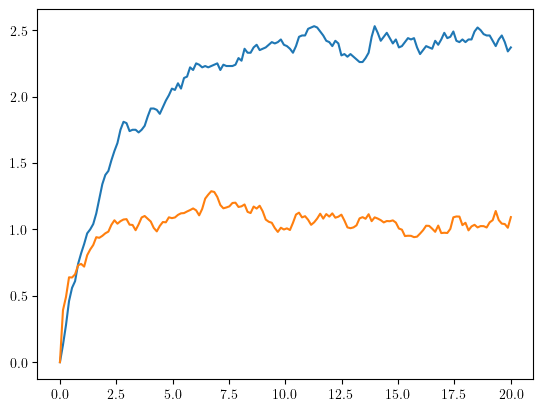

In [128]:
total_time = 20
ts = np.linspace(0, total_time, 150)
walk_samples = 100
walks = [simulate_walk(total_time) for _ in range(walk_samples)]
sampled_walks = [sample_walk(walk, ts) for walk in walks]
ranks = np.array([[sum(state) for state in walk] for walk in sampled_walks])
for rank in ranks:
    plt.plot(ts, rank)
plt.show()

plt.plot(ts, np.mean(ranks, axis=0))
plt.plot(ts, np.std(ranks, axis=0))
plt.show()

500

## Multivariate Normal Fitting

In [181]:
d = 10
N = int(1e4)
L = np.zeros((d,d))
for i in range(d):
    for j in range(i+1):
        L[i,j] = 1/(i - j + 1)
L = np.array(L)
C = np.dot(L, L.T)
S = scipy.stats.multivariate_normal.rvs(np.zeros(d), C, size=N)

In [182]:
L

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.5       , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.5       , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.25      , 0.33333333, 0.5       , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.2       , 0.25      , 0.33333333, 0.5       , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16666667, 0.2       , 0.25      , 0.33333333, 0.5       ,
        1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.14285714, 0.16666667, 0.2       , 0.25      , 0.33333333,
        0.5       , 1.        , 0.        , 0.        , 0.        ],
       [0.125     , 0.14285714, 0.1666666

(array([   5.,   57.,  344., 1249., 2413., 2890., 2022.,  814.,  169.,
          37.]),
 array([-3.97845919, -3.22894017, -2.47942115, -1.72990212, -0.9803831 ,
        -0.23086408,  0.51865494,  1.26817396,  2.01769298,  2.76721201,
         3.51673103]),
 <BarContainer object of 10 artists>)

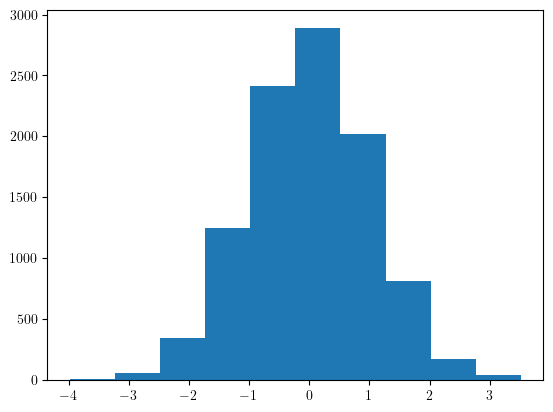

In [183]:
plt.hist(S[:,0])

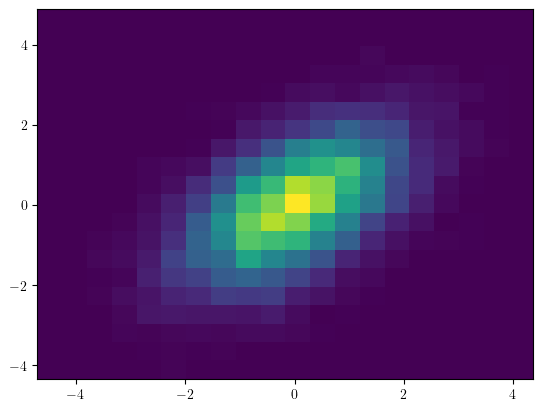

In [185]:
plt.hist2d(S[:,2], S[:,3], bins=(20,20))
plt.show()

In [149]:
S.shape

(10000, 10)